# Bayesian Inference of Enzyme kinetics - Simulation example

This notebook will show a basic setup for performing Bayesian inference on enzyme data to estimate kinetic parameters, using a hypothetical one-substrate enzymatic system.

In [1]:
# Standard scientific imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate 

# Bayesian inference imports
import pymc3 as pm
import arviz as az
import theano.tensor as tt

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='notebook', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-11 14:21:29

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.2.0

pandas    : 1.2.4
theano    : 1.1.2
arviz     : 0.11.4
matplotlib: 3.4.3
seaborn   : 0.11.2
scipy     : 1.6.3
numpy     : 1.20.3
pymc3     : 3.11.4



## Data generation

Data is generated by integrating a Michaelis-Menten type ODE and collecting the resulting product steady-state concentrations at different input substrate concentrations.

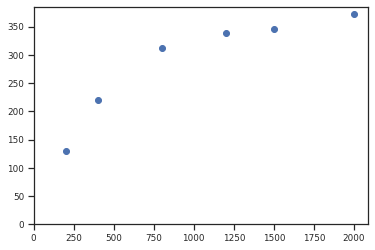

,S_in,P_obs,S_obs
0,200,129.904309,70.095691
1,400,219.502192,180.497808
2,800,312.498198,487.501802
3,1200,337.860402,862.139598
4,1500,345.958311,1154.041689
5,2000,372.767121,1627.232879


In [2]:
k_cat_real = 50
K_M_real = 150

E_conc = 1.0

kf = 0.125

noise = 5

def reactor(c, t, S_in):
    S, P = c
    v = k_cat_real * E_conc * S/(K_M_real + S)
    return [
        -v - kf*(S-S_in),
        v - kf*P
    ]

def generate_data(S_range, noise):
    steady_state_data = []

    for S_in in S_range:
        steady_state = integrate.odeint(reactor, [S_in, 0], np.linspace(0, 200, 100), args=(S_in,))[-1, 1]
        steady_state_data.append(steady_state)
    return np.array(steady_state_data) + np.random.normal(loc=0.0, scale=noise, size=len(S_range))

Substrate_range = np.array([200, 400, 800, 1200, 1500, 2000])
data = generate_data(Substrate_range, noise=noise)

df_data = pd.DataFrame({'S_in': Substrate_range, 'P_obs': data, 'S_obs': Substrate_range - data})

plt.scatter(Substrate_range, data)
plt.xlim(0)
plt.ylim(0)
plt.show()
df_data

## Model definition and sampling

A simple Bayesian model for the steady-state concentration is written down, together with uninformative priors that we know include the true kinetic parameter values.

In [3]:
with pm.Model() as model:
    # Stating the priors
    k_cat = pm.Uniform("k_cat", 0, 100)
    K_M = pm.Uniform("K_M", 0, 500)
    sigma = pm.Exponential("sigma", 10)

    # We extract all data from the dataframe here so the likelihood is easier to write down
    S_in = df_data["S_in"].values
    P_obs = df_data["P_obs"].values
    S_obs = df_data["S_obs"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", 
        mu=k_cat * E_conc * S_obs / (kf * (K_M + S_obs)), 
        sigma=sigma, 
        observed=P_obs
    )

In [4]:
with model:
    idata = pm.sample(
        1000,
        tune=1000,
        cores=8,
        step=pm.NUTS(),
        return_inferencedata=True,
    )

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, K_M, k_cat]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


## Posterior analysis

The posterior obtained via sampling can be analyzed numerically, or by plotting. 
Generally, the posterior distributions include the true values inside their 94% confidence interval.

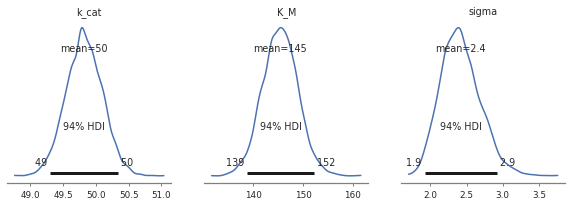

In [5]:
with model:
    az.plot_posterior(idata, figsize=(10,3))

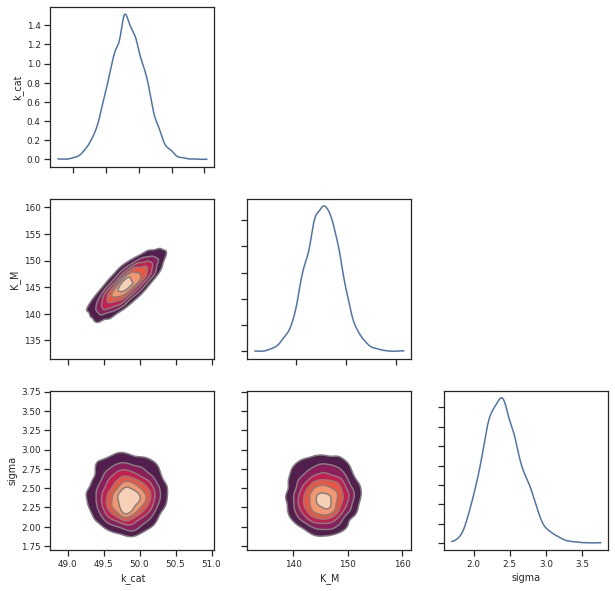

In [6]:
with model:
    az.plot_pair(idata, marginals=True, kind='kde', divergences=True, figsize=(10,10))

## Same example with more observation points

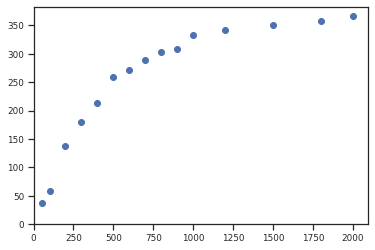

,S_in,P_obs,S_obs
0,50,37.229037,12.770963
1,100,57.787845,42.212155
2,200,137.464556,62.535444
3,300,180.002512,119.997488
4,400,214.245744,185.754256
5,500,258.468008,241.531992
6,600,271.124730,328.875270
7,700,288.831215,411.168785
8,800,303.117105,496.882895
9,900,308.894369,591.105631


In [9]:
Substrate_range = np.array([50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1800, 2000])
data = generate_data(Substrate_range, noise=5)

df_data = pd.DataFrame({'S_in': Substrate_range, 'P_obs': data, 'S_obs': Substrate_range - data})

plt.scatter(Substrate_range, data)
plt.xlim(0)
plt.ylim(0)
plt.show()
df_data

In [10]:
with pm.Model() as model:
    # Stating the priors
    k_cat = pm.Uniform("k_cat", 0, 100)
    K_M = pm.Uniform("K_M", 0, 500)
    sigma = pm.Exponential("sigma", 1)

    # We extract all data from the dataframe here so the likelihood is easier to write down
    S_in = df_data["S_in"].values
    P_obs = df_data["P_obs"].values
    S_obs = df_data["S_obs"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", 
        mu=k_cat * E_conc * S_obs / (kf * (K_M + S_obs)), 
        sigma=sigma, 
        observed=P_obs
    )

In [11]:
with model:
    idata = pm.sample(
        1000,
        tune=1000,
        cores=8,
        step=pm.NUTS(target_accept=0.85),
        return_inferencedata=True,
    )

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, K_M, k_cat]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


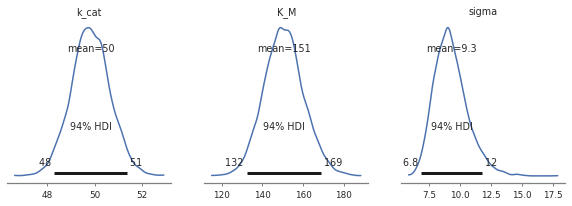

In [12]:
with model:
    az.plot_posterior(idata, figsize=(10,3))